## Assignment 3

Name: Zenas Huang

In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#read-in the pca data
data = pd.read_csv('./pca-data.txt',sep='\t',header=None)
data_array = np.asarray(data)
data.head()

,0,1,2
0,5.906263,-7.729465,9.144945
1,-8.640323,1.724260,-10.696805
2,0.258541,0.230622,0.767439
3,-5.234354,3.194685,-1.894385
4,12.622863,-3.507888,4.086258


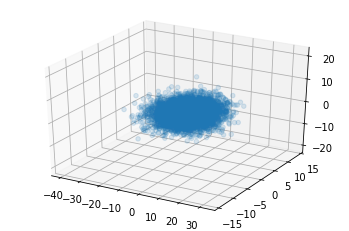

In [3]:
#visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=data_array[:,0],ys=data_array[:,1],zs=data_array[:,2], alpha = 0.15);

### Principal Components Analysis (PCA)

In [4]:
def PCA(A, dims):
    #pre-processing: demean the data
    means = [A[:,i].mean() for i in range(A.shape[1])]
    for j in range(A.shape[1]):
        A[:,j] = A[:,j] - means[j]
    #Compute the Covariance Matrix
    X = [np.outer(A.T[:,i],A[i,:]) for i in range(len(A))]
    Sigma = np.sum(X,axis=0)
    Covariance = (1/len(A))*Sigma
    #Eigenvalue Decomposition
    eigenValues, eigenVectors = np.linalg.eig(Covariance)
    #sort and return the indices from largest to smallest eigenvalues
    index = eigenValues.argsort()[::-1]
    #sort the eigenvectors from largest to smallest according to their magnitudes i.e. respective eigenvalues 
    eigenVectors = eigenVectors[:,index]
    U_tr = eigenVectors[:,:dims]
    Z = np.matmul(U_tr.T,A.T)
    Z = Z.T
    return Z, U_tr

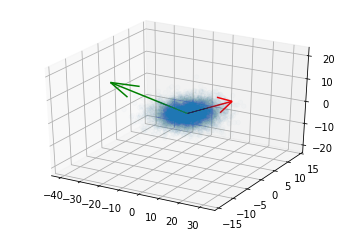

array([[ 0.867, -0.496],
       [-0.233, -0.492],
       [ 0.441,  0.715]])

In [5]:
#Run the PCA
transformed = PCA(data_array,2)
np.round(transformed[1],3)
origin = [0,0,0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=data_array[:,0],ys=data_array[:,1],zs=data_array[:,2], alpha = 0.01);
ax.quiver(*origin,transformed[1][:,0][0],transformed[1][:,0][1],transformed[1][:,0][2],length=40,color='r')
ax.quiver(*origin,transformed[1][:,1][0],transformed[1][:,1][1],transformed[1][:,1][2],length=30,color='g')
plt.show();
#plot of the 2 Principal Component Directions of the original 3D PointCloud
#The two principal component vectors of the original 3D point cloud as column vectors
np.round(transformed[1],3)

In [6]:
#using a vectorized calculation the covariance matrix
# we can find the principal components of the 2D data in eVectors
cov = np.dot(transformed[0].T,transformed[0])/len(transformed[0])
#retrieve the eigenvalues and 2D eigenvectors
eValues, eVectors = np.linalg.eig(cov)

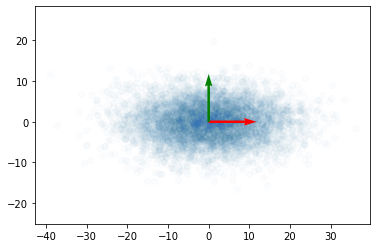

array([[ 1.00000000e+00,  7.25033861e-16],
       [-7.25033861e-16,  1.00000000e+00]])

In [7]:
plt.scatter(transformed[0][:,0],transformed[0][:,1],alpha =0.02)
origin = [0,0]
plt.quiver(*origin,eVectors[0],eVectors[1],color=['r','g'],scale=7)
plt.axis('equal')
plt.show();
#plot of the PCA transformed Z-data mapped to 2Dimensions with it's two principal component directions
#principal component vector on the projected 2D pointcloud
eVectors

### FastMap 

In [8]:
#distance function 
def df(Oa,Ob,jthCoord):
    #establish initial distance "function" via a mapping matrix for pairwise distances lookup based off data.txt
    #(N+1)x(N+1) for python zero index offset so that objectID matches row/column no.
    distances = np.zeros((len(wordlist)+1,len(wordlist)+1))
    with open('fastmap-data.txt','r') as data:
        for line in data:
            i = int(line.strip().split('\t')[0])
            j = int(line.strip().split('\t')[1])
            d = int(line.strip().split('\t')[2])
            distances[i][j] = d
            #symmetric pairwise distances
            distances[j][i] = d
    data.close()
        
    if(jthCoord == 1):
        #on first iteration get distance
        return distances[Oa][Ob]
    else:
        #redefine distance function for next coordinate
        newDf = math.sqrt(df(Oa,Ob,jthCoord-1)**2 - (embed[Oa][jthCoord-1]-embed[Ob][jthCoord-1])**2)
        return newDf

#find farthest-two-objects function in step 1
def getFurthestPair(jthCoord):
    Ob = random.randint(1,len(wordlist)) #choose a random pivot from [1-10] incluseive-inclusive
    #set candidate holders
    furthest, bestA, bestB = 0, 0, 0
    #run linear search for 5-7 pivots per professor's heuristic recommendation
    for i in range(0,7):
        currentDistance = 0
        #search distances for the current pivot Ob
        for Oi in range(1,len(wordlist)+1): #get distances for objects from [1-11) inclusive-exclusive
            ObDistance = df(Ob,Oi,jthCoord)
            if(currentDistance < ObDistance):
                currentDistance = ObDistance
                Oa = Oi
        #if current distance is farther, update the overall furthest pair
        if(furthest < currentDistance):
            furthest = currentDistance
            bestA = Oa
            bestB = Ob
        #otherwise if distance has not increased then check current pair against best and update best pair
        elif(furthest >= currentDistance):
            if((bestA,bestB) == (Oa,Ob) or ((bestA,bestB) == (Ob,Oa))):
                bestA = Oa
                bestB = Ob
        #change pivot for next search iteration
        Ob = Oa
    return bestA, bestB

In [9]:
def FastMap(k,jthCoord, wordlist,embed):
    #from blackboard paper pseudocode
    #check stopping condition
    if(k<=0):
        return
    else:
        jthCoord = jthCoord+1
    Oa,Ob = getFurthestPair(jthCoord)

    #check if end cases are identified, if so then all coordinates zero and break
    if(df(Oa,Ob,jthCoord) == 0):
        for Oi in range(1,len(wordlist)+1):
            embed[i][jthCoord] = 0
        return
    #step 2
    for Oi in range(1,len(wordlist)+1):
        #get projection distance for each objects by cosine law formula
        if(Oi!= Oa and Oi != Ob):
            projDist = ((df(Oa,Oi,jthCoord)**2)+(df(Oa,Ob,jthCoord)**2)-(df(Ob,Oi,jthCoord)**2))/(2*df(Oa,Ob,jthCoord))
        #endpoint cases
        elif(Oi == Oa):
            projDist = 0
        elif(Oi == Ob):
            projDist = df(Oa,Ob,jthCoord)

        embed[Oi][jthCoord] = projDist
    #increment and call again 
    FastMap(k-1,jthCoord,wordlist,embed)

In [10]:
#read in wordlist data
wordlist = []
with open('fastmap-wordlist.txt','r') as words:
    for line in words:
        wordlist.append(line.strip('\n'))
words.close()
#set number of embedding dimensions
k=2
#initialize P coord matrix Nx(k+1) (for zero index offset)
embed = np.zeros((len(wordlist)+1,k+1)) 

#fix random seed 
random.seed(0)
#run fastmap embedding
FastMap(k,0,wordlist,embed)
#output 2D coordinates of word objects
embedding = embed[:,1:][1:,:]
np.round(embedding,2)

array([[ 8.12,  6.06],
       [ 9.  ,  7.75],
       [12.  ,  4.  ],
       [10.96,  1.19],
       [ 9.54,  0.  ],
       [ 2.5 ,  5.19],
       [ 9.54,  8.  ],
       [10.5 ,  1.56],
       [ 9.54,  1.  ],
       [ 0.  ,  4.  ]])

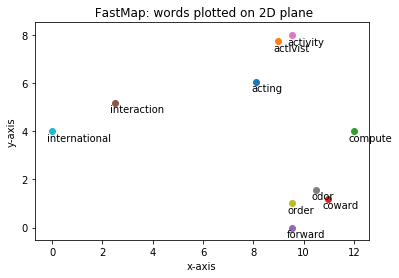

In [11]:
#Plot words on 2D plane
for word in range(len(wordlist)):
    plt.scatter(embedding[word][0],embedding[word][1])
    plt.annotate(wordlist[word],(embedding[word][0]-.2,embedding[word][1]-.4))
    #for coordinates uncomment below
#    plt.annotate((round(embedding[word][0],2),round(embedding[word][1],2)),(embedding[word][0],embedding[word][1]))
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title(' FastMap: words plotted on 2D plane')
plt.show();